# Project - MS&E 223 Simulations
## Catherine Gu
### June 2019

### Q1
X represents the amount of cash obtained at the end of the first period, by liquidating the risky asset and the risk free asset, taking into account of the transaction cost for the risky asset. The amount of allocation needs to be decided *ex-ante* at time period 0 but the realized cash X is determined *ex-post* by the asset prices at the end of time period 1.

The exact expression for X should therefore be:

$$ X = \theta(0) * F(1) + \phi(0) * S(1) - \phi^2(0) * \rho * S(1) $$

### Q2 a)

#### Overview
The utility function is:
$$u(x) = log(max(x, 0))$$

Our objective function is to find the optimal ex-ante allocation to the risky asset at time period 0, $\phi(0)$, which will maximize our utility function: $$max_{\theta(0), \phi(0)} E[u(X)]$$

Before implementing the algorithm, there are a few features for the objective function interesting to note. Given the utility function is described by a log function, we can infer that the choice of the optimal allocation will never result in X approaching zero or negative, because the expected utility will approach negative $\infty$ when X is close to zero and would therefore not be a maximizer. As a result, one feature that this utility function has ruled out is the possibility of shorting, because by shorting the risky asset, there is a non-zero probability where $X \leq 0$ if the risky asset price experiences a positive jump in period 1. *Translating this into codes below, I have imposed a **no-shorting** condition as bounds on the optimal allocations for the risky asset and the risk free asset.* The log utility function thus favours more *conservative* investment allocation decisions, where most of the budget will be invested in safe, risk free asset and only a small proportion in the risky asset - indeed as we shall observe from our optimality result, the optimal allocation between risk free and risky asset is about 5:1 to 6:1 ratio. 


#### Constructing Multilevel Monte Carlo Estimators
The procedure for implementing an unbiased estimator $E[X^*] = \alpha = g(E[X])$ follows from using the randomised multilevel monte carlo method that we have discussed in Lecture 16 and 17 of this course. To construct the estimator $X^*$, setting n0 = 10, we do the following steps:

1. Sample N ~ Geometric(p) where $p = 1 - (\frac{1}{2})^{\frac{3}{2}}$. $N = Geo(p) + n0 -1$

2. Sample {$X_1, X_2... X_{2^{N+1}}$}.
In our case, $X_i$ represents samplings of the risky price, which is provided by the function **risky_price(num_samples, S0 = 2)** where num_samples = N, and S0 and other parameter values are provided by the question. Note the risky price, S1, is a random variable that depends on two underlying random variables: J and Z as described in the function. 

3. Once we have sampled $2^{N+n0+1}$ risky price samples, we can then construct g(X) which we denote as the optimiser, Opt. The maximum expected utility function is constructed using **util_optimiser(S1)** which takes samples of the risky price as input. 
The function maximizes the expected utility: $$Opt = max_{\theta}E[u(\theta, X)]$$
where u( ) represents the utility function, $\theta^*$ represents the *optimal* allocation of the risk free and risky asset, and X represents the risky price. We also include the *budget constraint*, together with the *no-shorting* condition as bounds:
$$b = \theta(0) * F(0) + \phi(0) * S(0) + \phi^2(0) * \rho * S(0)$$
$$\theta(0) \geq 0$$
$$\phi(0) \geq 0$$
The function returns two outputs: $\theta^*$ as the allocation variable for the risk free and risky asset, and $Opt^*$ as the maximum expected utility for Q2 b)

4. We can now implement our unbiased *cool estimator* $X^*$ using multilevel monte carlo method: $$\hat{\theta}^{cool} = \frac{\hat{\theta}(2^{N+1}) - \frac{1}{2}(\hat{\theta}^{even}(2^N) + \hat{\theta}^{odd}(2^N))}{p(N)} + \hat{\theta}(2^{n0})$$
We claim $E[X^*] = \alpha = g(E[X])$ which will be justified in part b).

5. Once we have found $X^*$, we can then proceed using standard Monte Carlo method by repeating Step 1 - 4 for $n$ number of iterations. To satisfy a specified confidence level and error, we need to determine the minimum number of iterations, $n$, needed iteratively through output analysis in the algorithm. However, in cases where the convergence will happen rather quickly, e.g. when $n$ required to achieve the desired C.I and error is small, I have chosen as a ball park to run the simulation 10,000 times *at least* to achieve an accurate estimate for each question set. Reverting to **output analysis** in our final step, by sampling {$X^*_1, X^*_2... X^*_{n}$} i.i.d. copies of $X^*$, we can obtain an estimate for $E[X^*]$ using the Law of Large Number:
$$\alpha_n^* = \frac{X^*_1 + ... + X^*_{n}}{n}$$
then following from the Central Limit Theroem, *assuming unbiasedness and finite variance of our cool estimator* (Q2 b), one can obtain the minimum $n$ number of samples required by examining the following condition:
$$\alpha_n^* = \alpha + \frac{\sqrt{Var(X^*)}}{\sqrt{n}}N(0,1)$$
i.e. $n$ needs to satisfy: $$\epsilon \geq \frac{z_{1-\delta}\hat{\sigma_n}}{\sqrt{n}}$$
For the project, we assume 5% error and 95% confidence.


In [201]:
import numpy as np
import scipy.stats as sct
from scipy.stats import geom
import matplotlib.pyplot as plt
from scipy.special import ndtri
from scipy.optimize import minimize
import math

In [202]:
def risky_price(num_samples, S0 = 2):
    ## S1 = S0 * R
    ## log(R_t) = (mu_0 + Z_t * sigma_0) * J_t + (mu_1 + Z_t * sigma_1) * (1 - J_t)
    ## J ~ Ber(p), Z ~ N(0,1)
    
    ## parameter values given
    p = 0.4
    mu_0 = 0.1
    sigma_0 = 0.15
    mu_1 = 0.25
    sigma_1 = 0.3
    
    J = np.random.binomial(1, p, size = (1, num_samples))
    Z = np.random.normal(0, 1, size = (1, num_samples))
    log_R = (mu_0 + Z * sigma_0) * J + (mu_1 + Z * sigma_1) * (1 - J)
    R = np.exp(log_R)
    S1 = S0 * R
    return S1

In [203]:
def util_optimiser(S1):
    '''
    a function that maximizes the expected utility by solving for the optimal asset allocation between
    the risky and the risk free asset
    '''
    
    ## parameter values given
    F0 = 1
    S0 = 2  
    b = 200
    rho = 0.01
    
    ## F1 = exp(r) * F0
    r = 0.03
    F1 = np.exp(r) * F0
    
    ## max expected utility function
    util = lambda x: (-1) * np.mean(np.log(np.max(x[0] * F1 + x[1] * S1 - x[1] ** 2 * rho * S1, 0)))

    const = ({'type': 'eq', 'fun': lambda x: (x[0] * F0 + x[1] * S0 + x[1] ** 2 * rho * S0 - b)})

    bnds = ((0, None), (0, None))

    res = minimize(util, (2,1), method = 'SLSQP', bounds = bnds, constraints = const)

    allocation = res.x
    opt = -1 * res.fun
    
    return allocation, opt

In [264]:
def finding_opt_risky_allocation(n_0, delta, epsilon, burn_in):    
    '''
    This function uses the multi-level MC steps to compute the optimal risky asset allocatin given
    confidence interval and error
    '''    
    
    # Do the experiment
    # experiment variables
    z = sct.norm.ppf( 1 - delta/2 )  # 1 - delta/2 quantile of N(0, 1)
    r_star = 1 - pow( 2, -1.5 )     # optimal success rate for the geometric of N

    confidence_interval = float( 'inf' )
    running_mean = 0
    running_2moment = 0
    num_estimator = 0     #count of number of estimators generated                      
    Max_experiment = 50000
    
    CIs = np.zeros((1, Max_experiment))
    estimation = np.zeros((1, Max_experiment))

    while num_estimator < 10000 or confidence_interval >= epsilon and num_estimator < Max_experiment:
        N = np.random.geometric( p=r_star )

        num_samples = pow(2, N+n_0+1)
        
        samples = risky_price(num_samples) #sampling S1
        
        samples_odd = samples[:,0::2]
        samples_even = samples[:,1::2]
        samples_n_0 = samples[:,0:pow(2,n_0)]

        [alloc_Nplus1, opt_Nplus1] =  util_optimiser(samples)
        [alloc_N_odd, opt_N_odd] = util_optimiser(samples_odd)
        [alloc_N_even, opt_N_even] = util_optimiser(samples_even)
        [alloc_N0, opt_N0] = util_optimiser(samples_n_0)

        X_star = (alloc_Nplus1[1] - (alloc_N_odd[1] + alloc_N_even[1]) / 2) / sct.geom(r_star).pmf(N+1) + alloc_N0[1]   

        running_mean = (running_mean * num_estimator + X_star) / (num_estimator + 1)
        running_2moment = (running_2moment * num_estimator + pow(X_star, 2)) / (num_estimator + 1)
        sample_std = math.sqrt(running_2moment - pow(running_mean, 2))
        num_estimator = num_estimator + 1
        confidence_interval = z * sample_std / (math.sqrt(num_estimator) * running_mean) #relative error
        estimation[:,num_estimator-1] = running_mean
        CIs[:,num_estimator-1] = confidence_interval

    lower = estimation - CIs
    upper = estimation + CIs

    print('Generate', num_estimator , 'samples \n')
    n_range = np.arange(burn_in-1, num_estimator)
    plt.plot(n_range, estimation[0,n_range], label='estimation')
    plt.plot(n_range, lower[0,n_range],  label='lower CI')
    plt.plot(n_range, upper[0,n_range], label='upper CI')
    plt.legend(loc='upper right')
    plt.show()

    return running_mean

Generate 10000 samples 



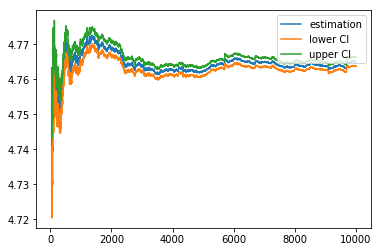

4.765071968425329

In [216]:
finding_opt_risky_allocation(10, 0.05, 0.05, 50)

#### Result - Optimal Risky Allocation
By running the monte carlo simulation 10,000 times which achieves a result of at least 95% confidence and 5% relative error, we have found the optimal allocation into risky asset at period 0 is around 4.77. This confirms our initial intuition where by introducing a log utility function as our utility maximizer, one tends to construct a conservative portoflio with majority of the asset being invested in the risk free asset and only a small amount in the risky asset.





### Q2 b)

The second part of this question follows a similar implementation procedure in estimating the maximum expected utility function. Again using the multilevel monte carlo procedure, Step 1 - 3 are the same in terms of generating N, $X_i$ samples of *risky_price()* and outputing *utility_optimiser()*. 

Step 4 differs in the construction of the cool estimator, $X^*$:
$$Opt^{cool} = \frac{Opt(2^{N+1}) - \frac{1}{2}(Opt^{even}(2^N) + Opt^{odd}(2^N))}{p(N)} + Opt(2^{n0})$$
where Opt is the output variable from the utility_optimiser() function.

We can then revert back to the usual monte carlo procedure in Step 5 to complete our output analysis.


#### Justification for using $E[X^*]$
We want to make sure the estimator that we have constructed for $\alpha = g(E[X])$ satisfies the following three properties: 1) Unbiasedness; 2) Finite Variance; 3) The cost of simulation has finite mean. Since by property 1 and 2, we are then justified to apply the **Central Limit Theorem** presented in Step 5 of Q2 a) to conduct output analysis, and by property 3 we can control for the cost of simulation in a manageable manner. 

To prove unbiasedness, we apply some statistical tricks by conditioning our estimator on N where $ N = Geo(p) + n0 -1$ and taking the telescopic decomposition on multiple "levels" to achieve the result that:
$$E[X^*] - E[g(\bar{X}_{2^{n0}})] = \alpha - E[g(\bar{X}_{2^{n0}})]$$
Thus we get: $$E[X^*] = \alpha$$

To prove finite variance, we use Taylor series to measure error between levels. Since $Var(X^*) = E[(X^*)^2] - (E[X^*])^2 \leq E[(X^*)^2]$. We can verify that $E[(X^*)^2] \leq \infty$ by applying a Tayor expansion on $g(\bar{X}_{2^{n+1}})$ to prove our estimator has finite variance.

Lastly to make sure that property 3 is satisfied, we select a value of $p(k)$, where $p(k) = p(1-p)^{k-n0}$, for the Geometric distribution that ensures the cost of simulating $X^*$ is finite. Minimizing the total cost of simulating variables with respect to $p$, we found that $p$ must lie between $\frac{1}{4} \leq p \leq \frac{1}{2}$. This is why $p$ is chosen to be $p = 1 - (\frac{1}{2})^{\frac{3}{2}}$ in the setup of the multilevel monte carlo estimation. 

In [265]:
def finding_opt(n_0, delta, epsilon, burn_in):    
    '''
    This function uses the multi-level MC steps to compute the maximum expected utility given
    confidence interval and error
    
    '''    
    
    # Do the experiment
    # experiment variables
    z = sct.norm.ppf( 1 - delta/2 )  # 1 - delta/2 quantile of N(0, 1)
    r_star = 1 - pow( 2, -1.5 )     # optimal success rate for the geometric of N

    confidence_interval = float( 'inf' )
    running_mean = 0
    running_2moment = 0
    num_estimator = 0     #count of number of estimators generated                      
    Max_experiment = 50000
    
    CIs = np.zeros((1, Max_experiment))
    estimation = np.zeros((1, Max_experiment))

    while num_estimator < 10000 or confidence_interval >= epsilon and num_estimator < Max_experiment:
        N = np.random.geometric( p=r_star )

        num_samples = pow(2, N+n_0+1)
        
        samples = risky_price(num_samples) #sampling S1
        
        samples_odd = samples[:,0::2]
        samples_even = samples[:,1::2]
        samples_n_0 = samples[:,0:pow(2,n_0)]

        [alloc_Nplus1, opt_Nplus1] =  util_optimiser(samples)
        [alloc_N_odd, opt_N_odd] = util_optimiser(samples_odd)
        [alloc_N_even, opt_N_even] = util_optimiser(samples_even)
        [alloc_N0, opt_N0] = util_optimiser(samples_n_0)

        X_star = (opt_Nplus1 - (opt_N_odd + opt_N_even) / 2) / sct.geom(r_star).pmf(N+1) + opt_N0   

        running_mean = (running_mean * num_estimator + X_star) / (num_estimator + 1)
        running_2moment = (running_2moment * num_estimator + pow(X_star, 2)) / (num_estimator + 1)
        sample_std = math.sqrt(running_2moment - pow(running_mean, 2))
        num_estimator = num_estimator + 1
        confidence_interval = z * sample_std / (math.sqrt(num_estimator) * running_mean) #relative error
        estimation[:,num_estimator-1] = running_mean
        CIs[:,num_estimator-1] = confidence_interval

    lower = estimation - CIs
    upper = estimation + CIs

    print('Generate', num_estimator , 'samples \n')
    n_range = np.arange(burn_in-1, num_estimator)
    plt.plot(n_range, estimation[0,n_range], label='estimation')
    plt.plot(n_range, lower[0,n_range],  label='lower CI')
    plt.plot(n_range, upper[0,n_range], label='upper CI')
    plt.legend(loc='upper right')
    plt.show()

    return running_mean

Generate 10000 samples 



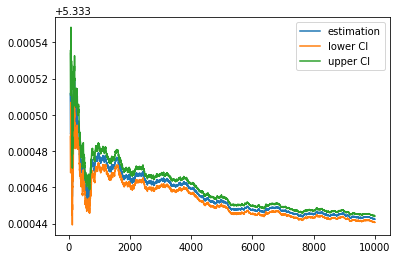

5.333442425355806

In [218]:
finding_opt(10, 0.05, 0.05, 50)

#### Result - Maximum Expected Utility
By running the monte carlo simulation 10,000 times which achieves a result of at least 95% confidence and 5% relative error, we have found the maximum expected utility to be 5.33. The graph plots the upper and the lower bounds of the estimation by tracking the confidence interval around the running mean. 

### VaR - Loss Estimation

We apply the same technique using multilevel Monte Carlo method to obtain an unbiased estimator for the losses. The function we are looking to estimate is the Value-at-Risk at the 95-th quantile. 

Defining losses to be $L = max(b-X, 0)$, we want to produce $E[X^*] = \hat{\theta}_.95$ with $P(L \leq \hat{\theta}_.95) = .95$. For construction, we build a *loss* fucnction that takes in the sampled risky prices and compute the losses each time as defined above. The sampled losses are then sorted by their respective magnitude and we select the 95th largest losses from each sampling series to compute $X^*$ estimator. Lastly, the output analysis follows the same procedure as before.

In [6]:
def loss(S1, F1 = np.exp(0.03) * 1):
    allocation, opt = util_optimiser(S1)
    X = allocation[0] * F1 + allocation[1] * S1 - allocation[1] ** 2 * 0.01 * S1
    loss = np.maximum(200 - X, 0)
    return loss

In [7]:
def sanity_check(samples):
    loss_sample = loss(samples).squeeze()
    count = [1 for loss in loss_sample if loss > 0]
    prob = np.sum(count) / loss_sample.size
    return prob

In [266]:
def VaR_estimate(n_0, delta, epsilon, burn_in):    
    '''
    This function uses the multi-level MC steps to compute the VaR of losses at 95% quantile given
    confidence interval and error
    
    '''    
    
    # Do the experiment
    # experiment variables
    z = sct.norm.ppf( 1 - delta/2 )  # 1 - delta/2 quantile of N(0, 1)
    r_star = 1 - pow( 2, -1.5 )     # optimal success rate for the geometric of N

    confidence_interval = float( 'inf' )
    running_mean = 0
    running_2moment = 0
    num_estimator = 0     #count of number of estimators generated                      
    Max_experiment = 50000
    
    CIs = np.zeros((1, Max_experiment))
    estimation = np.zeros((1, Max_experiment))
    
    while num_estimator < 10000 or confidence_interval >= epsilon and num_estimator < Max_experiment:
        N = np.random.geometric( p=r_star )

        num_samples = pow(2, N+n_0+1)
        
        samples = risky_price(num_samples) #sampling S1
        samples_odd = samples[:,0::2]
        samples_even = samples[:,1::2]
        samples_n_0 = samples[:,0:pow(2,n_0)]
        
        q = 0.95
        loss_Nplus1 =  np.quantile(loss(samples), q)
        loss_N_odd = np.quantile(loss(samples_odd), q)
        loss_N_even = np.quantile(loss(samples_even), q)
        loss_N0 = np.quantile(loss(samples_n_0), q)
        
        ##sanity check on losses
        if (num_estimator % 1000 == 0):
            if (sanity_check(samples) > 0.05 or sanity_check(samples_odd) > 0.05 or 
              sanity_check(samples_even) > 0.05 or sanity_check(samples_n_0) > 0.05):
                print(num_estimator, "th iteration has P(b>X) > 0.05")
            print("none of the sampled iterations has P(b>X) > 0.05 probability")
            
        X_star = (loss_Nplus1 - (loss_N_odd + loss_N_even) / 2) / sct.geom(r_star).pmf(N+1) + loss_N0 
        
        running_mean = (running_mean * num_estimator + X_star) / (num_estimator + 1)
        running_2moment = (running_2moment * num_estimator + pow(X_star, 2)) / (num_estimator + 1)
        sample_std = math.sqrt(running_2moment - pow(running_mean, 2))
        num_estimator = num_estimator + 1
        confidence_interval = z * sample_std / (math.sqrt(num_estimator) * running_mean) #relative error
        estimation[:,num_estimator-1] = running_mean
        CIs[:,num_estimator-1] = confidence_interval

#     lower = estimation - CIs
#     upper = estimation + CIs

    print('Generate', num_estimator , 'samples \n')
    n_range = np.arange(burn_in-1, num_estimator)
    plt.plot(n_range, estimation[0,n_range], label='estimation')
#     plt.plot(n_range, lower[0,n_range],  label='lower CI')
#     plt.plot(n_range, upper[0,n_range], label='upper CI')
    plt.legend(loc='upper right')
    plt.show()

    return running_mean

none of the sampled iterations has P(b>X) > 0.05 probability


/anaconda3/envs/mypython/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


none of the sampled iterations has P(b>X) > 0.05 probability
none of the sampled iterations has P(b>X) > 0.05 probability
none of the sampled iterations has P(b>X) > 0.05 probability
none of the sampled iterations has P(b>X) > 0.05 probability
none of the sampled iterations has P(b>X) > 0.05 probability
none of the sampled iterations has P(b>X) > 0.05 probability
none of the sampled iterations has P(b>X) > 0.05 probability
none of the sampled iterations has P(b>X) > 0.05 probability
none of the sampled iterations has P(b>X) > 0.05 probability
Generate 10000 samples 



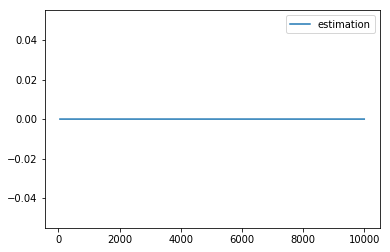

0.0

In [248]:
VaR_estimate(10, 0.05, 0.05, 50)

#### Result - VaR & Sanity Check

The VaR at the 95-th quantile is 0 when running 10,000 simulations with at least 95% confidence and at most 5% relative error. For this part of the question, we also introduce a *sanity_check* function to verify our confidence level of at least 95% by counting the number of non-zero losses (since $L$ is a number that is $\geq 0$) produced in each run and compute the probability $P(b<X)$. If the simulation result is correct, then the probability $P(b<X)$ must not be greater than 0.05. We sanity check the above condition is true at every 1000 iterations and print out the result to verify our finding. 

Intuitively, it also aligns with expectation because as discussed at the beginning of Question 2, we expect to construct a conservative portfolio where allocation to the risky asset is relatively low and hence it is very unlikely where one would still end up with a portfolio that is losing money over the two-period horizon, since the risk free asset price is deterministic, that scenario requires a very large negative price shock to the risky asset to result in portfolio loss. 

## Q3 Variance Reduction

We implement three different types of variance reduction techniques on each of the first two parts of Question 2 while ensuring unbiasedness for our estimators. The graphs and numbers illustrate the effectiveness of dfferent methods when comparing to the *plain* version we used for the previous question.

### Stratified Sampling Technique
By looking at the general estimator that we have been applying to each part of the question so far, following the multilevel Monte Carlo method, we have:
$$X^* = \frac{g(\bar{X}_{2^{N+1}}) - (g(\bar{X}^{odd}_{2^{N}}) + g(\bar{X}^{even}_{2^{N}})) / 2}{p(1-p)^{N-n0}}$$

The idea of stratified sampling is to simulate the estimator $Y_i$ given $Z = i$ for each i-th strata. If we can compute $P(Z= i )$ and we have a certain simulation budget constraint for max_sample of replications, we can then obtain a conditional expected value for our estimator Y by obtaining the expected value as: $\sum Y_i * p(Z = i)$. 

In the setup for multilevel Monte Carlo, we can apply the stratification technique on: $$N = Geo(p) + n0 -1, \text{ where  } p = 1 - (\frac{1}{2})^{\frac{3}{2}}$$ 

Given $\mu_{Geo}(p) = \frac{1}{p} \approx 1.5$, we create four levels of strata around $\mu_{Geo}(p)$ by setting $1, 2, 3$ and $Geo(p) \geq 4$ strata. Once we condition on $N = Strata[i]$, we then construct multilevel Monte Carlo estimators by using $N$ num_samples for each $Strata[i]$. And given the max_sample specified, we allocate a budget of $max\_sample \times p(i)$ iterations to simulate for each stratum conditional on their probability mass function. Our stratified estimator is computed as the weighted average of the multilevel Monte Carlo estimator conditional on the pmf for each stratum. We can then use this unbiased estimator for output analysis to determine the amount of variance reduction achieved by stratification. 

In [249]:
def stratified_sampling(Question, max_sample, delta, n_0):    
    '''
    This function uses stratified sampling for Q2 of the Project as a method of variance reduction technique
    '''    
    # Do the experiment
    # experiment variables
    z = sct.norm.ppf( 1 - delta/2 )  # 1 - delta/2 quantile of N(0, 1)
    r_star = 1 - pow( 2, -1.5 )     # optimal success rate for the geometric of N
    
    Stratas = [1, 2, 3, 4]
    M = len(Stratas)
    
    # probability and number of samples for each strata
    ps = np.zeros(M)
    Ns = np.zeros(M, dtype = int)
    
    #for N <= 1
    ps[0] = geom.cdf(Stratas[0], r_star)
    Ns[0] = np.round(ps[0] * max_sample)
    
    #for N = [2, 3]
    for i in range(1, M-1):
        ps[i] = geom.pmf(Stratas[i],r_star)
        Ns[i] = np.round(ps[i] * max_sample)
        
    #for N >= 4
    ps[M - 1] = 1 - geom.cdf(Stratas[M - 2],r_star)
    Ns[M - 1] = max_sample - np.sum(Ns) # round the last one so that the total # samples is equal to max_sample

    mean_bar = np.zeros(M) # mean in each strata
    var_bar = np.zeros(M) # variance in each strata
    
    
    # 1 to M-1 stratas
    for i in range(M - 1):
        N = Stratas[i]
        num_samples = pow(2, N+n_0+1)
        
        # sample Ns(i) many samples
        samples = np.zeros(Ns[i]);
        for j in range(Ns[i]):
            sample = risky_price(num_samples)
            
            sample_odd = sample[:,0::2]
            sample_even = sample[:,1::2]
            sample_n_0 = sample[:,0:pow(2,n_0)]

            [alloc_Nplus1, opt_Nplus1] =  util_optimiser(sample)
            [alloc_N_odd, opt_N_odd] = util_optimiser(sample_odd)
            [alloc_N_even, opt_N_even] = util_optimiser(sample_even)
            [alloc_N0, opt_N0] = util_optimiser(sample_n_0)
            
            if Question == "2a":
                samples[j] = (alloc_Nplus1[1] - (alloc_N_odd[1] + alloc_N_even[1]) / 2) / sct.geom(r_star).pmf(N+1) + alloc_N0[1] 
            elif Question == "2b":
                samples[j] = (opt_Nplus1 - (opt_N_odd + opt_N_even) / 2) / sct.geom(r_star).pmf(N+1) + opt_N0

        mean_bar[i] = np.mean(samples)
        var_bar[i] = np.var(samples)


    # last strata
    N_set = []
    while len(N_set) < Ns[M - 1]:
        N_sample = np.random.geometric(r_star, 1)
        if N_sample >= Stratas[M - 1]:
            N_set += [N_sample]
    samples = np.zeros(Ns[M - 1]);
    
    for j in range(Ns[M - 1]):
        N = int(N_set[j])
        num_samples = pow(2, N+n_0+1)
        
        sample = risky_price(num_samples)
            
        sample_odd = sample[:,0::2]
        sample_even = sample[:,1::2]
        sample_n_0 = sample[:,0:pow(2,n_0)]

        [alloc_Nplus1, opt_Nplus1] =  util_optimiser(sample)
        [alloc_N_odd, opt_N_odd] = util_optimiser(sample_odd)
        [alloc_N_even, opt_N_even] = util_optimiser(sample_even)
        [alloc_N0, opt_N0] = util_optimiser(sample_n_0)

        if Question == "2a":
            samples[j] = (alloc_Nplus1[1] - (alloc_N_odd[1] + alloc_N_even[1]) / 2) / sct.geom(r_star).pmf(N+1) + alloc_N0[1] 
        elif Question == "2b":
            samples[j] = (opt_Nplus1 - (opt_N_odd + opt_N_even) / 2) / sct.geom(r_star).pmf(N+1) + opt_N0


    mean_bar[M - 1] = np.mean(samples)
    var_bar[M - 1] = np.var(samples)

     # final estimation and CI
    estimate = np.sum(ps * mean_bar);
    half_interval_stratified = ndtri(1 - delta/2) * np.sqrt(np.sum(ps**2 * var_bar / Ns ))
    CI_stratified_control = [estimate - half_interval_stratified, estimate + half_interval_stratified]
    print('CI_stratified_control', CI_stratified_control)
    
    # plain sampling
    N_set = np.random.geometric(r_star, max_sample)
    samples = np.zeros(max_sample)
    
    for j in range(max_sample):
        N = N_set[j]
        num_samples = pow(2, N+n_0+1)
        
        sample = risky_price(num_samples)
            
        sample_odd = sample[:,0::2]
        sample_even = sample[:,1::2]
        sample_n_0 = sample[:,0:pow(2,n_0)]
        
        [alloc_Nplus1, opt_Nplus1] =  util_optimiser(sample)
        [alloc_N_odd, opt_N_odd] = util_optimiser(sample_odd)
        [alloc_N_even, opt_N_even] = util_optimiser(sample_even)
        [alloc_N0, opt_N0] = util_optimiser(sample_n_0)

        if Question == "2a":
            samples[j] = (alloc_Nplus1[1] - (alloc_N_odd[1] + alloc_N_even[1]) / 2) / sct.geom(r_star).pmf(N+1) + alloc_N0[1] 
        elif Question == "2b":
            samples[j] = (opt_Nplus1 - (opt_N_odd + opt_N_even) / 2) / sct.geom(r_star).pmf(N+1) + opt_N0


    mean_plain = np.mean(samples)
    var_plain = np.var(samples)

    # final estimation and CI
    estimate = mean_plain;
    half_interval_plain = ndtri(1 - delta/2) * np.sqrt(var_plain) / np.sqrt(max_sample);
    CI_plain = [estimate - half_interval_plain, estimate + half_interval_plain]
    print('CI_plain', CI_plain)

    diff = half_interval_stratified - half_interval_plain;

    reduction_percent = (half_interval_plain - half_interval_stratified) / half_interval_plain * 100;
    print(f'By using stratification in {max_sample} samples, we reduce the length of CI by {reduction_percent} percent \n')

In [254]:
stratified_sampling('2a',1000, 0.05, 10)

CI_stratified_control [4.743293797224981, 4.769459470992956]
CI_plain [4.741854548887705, 4.7875077182457115]
By using stratification in 1000 samples, we reduce the length of CI by 42.685964335163966 percent 



In [251]:
stratified_sampling('2a',10000, 0.05, 10)

CI_stratified_control [4.751743200991309, 4.762043368198731]
CI_plain [4.7575753305268895, 4.768812622799074]
By using stratification in 10000 samples, we reduce the length of CI by 8.339420583397295 percent 



In [252]:
stratified_sampling('2b',1000, 0.05, 10)

CI_stratified_control [5.33338516306272, 5.3334438553809695]
CI_plain [5.333407294575994, 5.3334687171160615]
By using stratification in 1000 samples, we reduce the length of CI by 4.444983577308639 percent 



In [256]:
stratified_sampling('2b',10000, 0.05, 10)

CI_stratified_control [5.33342130127387, 5.333439945836532]
CI_plain [5.333436858352844, 5.333455886331233]
By using stratification in 10000 samples, we reduce the length of CI by 2.0150103181491597 percent 



#### Result - Stratified Sampling
Stratefied sampling reduces variance because we are introducing more information by conditioning on $N$ ~ $Geo(p)$ for each stratum. 

Deciding on the max_sample budget for stratified sampling is an art rather than science and as an exercise for this part of the project, I am interested in exploring the effectiveness of stratified sampling when we have a relatively small budget for simulations against when we have a very generous amount.

The best variance reduction result is obtained when we can only run 1000 simulations in finding the optimal risky asset allocation for Q2 a): the variance around our estimation is reduced by 43% as a result of stratification. However, when the budget is generous and we can run 10,000 simulations, stratefied sampling method produces a much smaller effect of 8.3% and 2.0% reduction for Q2 a) and b), respectively. Observing the absolute upper and lower bounds of *CI_plain* in both parts of the question, we note the bounds are already very tight with highly accurate estimates. As a result, the variance reduction effect brought by stratified sampling diminishes.  

### Control Variate Technique

The idea of introducing a control variate $Z_{cv}$ is to construct a variable that has $E[Z_{cv}] = 0$ but is correlated with Y so that when we estimate $W = Y - \beta Z_{cv}$,  $Var(W)$ is smaller than the original $Var(Y)$ because of the correlation between $Y$ and $Z_{cv}$, while $W$ is still an unbiased estimator for $Y$. 

We can construct a control variate for $Y = g(\bar{X}_{2^{n0}})$. Observing the utility function that we are trying to optimize in order to obtain the optimal risky asset allocation for part a) and the maximum expected utility for part b), we notice that the utility function is a log function with risky price as its input variable. There are several approaches one can experiment to explore the effectiveness of different control variate. 

#### Approach 1
We postulate that $log(S1)$ should be somewhat correlated with the utility function that we are trying to optimize. To construct the control variate $Z_{cv}$, we need to have 
$$Z_{cv} = g(X) - E[g(X)] = log(S1) - E[log(S1)]$$

Expanding the second term:
$$E[log(S1)] = E[log(S0 * R)] = log(S0) + E[log(R)] = log(S0) + p\mu_0 + (1-p)\mu_1\$$

Thus:
$$Z_{cv} = log(S1) - log(S0) - p\mu_0 - (1-p)\mu_1$$


We can then apply the above to our estimator $Y = g(\bar{X}_{2^{n0}})$ as part of the last term of constructing the cool estimator, with $Y - \beta Z_{cv}$. **This is the approach we have implemented in code below.**

#### Approach 2
Since the utility function is a function of the underlying risky price, we can also simply choose S1 to construct the control variate:
$$Z_{cv} = S1 - E[S1]$$

Expanding the second term:
$$E[S1] = E[S0 * R] = S0 * E[R]$$

Since J ~ Ber(p), where J = {1, 0}, applying the tower property where:

$$E[R] = E[E[R | J]] = E[E[R_1\mathbb{1}_{J = 1} + R_0\mathbb{1}_{J = 0}]] = E[\mathbb{1}_{J = 1}E[R_1] + \mathbb{1}_{J = 0}E[R_0]]$$

$$E[S1] = S0 * (pE[R_1] + (1-p)E[R_0]) = S0 * (p(\mu_0 + \frac{\sigma_0^2}{2}) + (1-p)(\mu_1 + \frac{\sigma_1^2}{2}))$$

We can then construct the control variable in the same way as before.

In [267]:
def cv_approach(Question, delta, epsilon, max_samples, n_0):    
    '''
    This function introduces control variable for Q2 of the Project as a method of variance reduction technique
    '''    
    
    ## parameter values given
    S0 = 2  
    p_ber = 0.4
    mu_0 = 0.1
    mu_1 = 0.25
    
    # define the control variate : gamma(x) = logS - log(S0) -  (p * m0 + (1-p) * m1)  
    gamma = lambda S1: np.log(S1) - np.log(S0) - (p_ber * mu_0 + (1-p_ber) * mu_1)
    
    ## Do the experiment
    # experiment variables
    z = sct.norm.ppf( 1 - delta/2 )  # 1 - delta/2 quantile of N(0, 1)
    r_star = 1 - pow( 2, -1.5 )     # optimal success rate for the geometric of N
    
    num_estimator = 0     #count of number of estimators generated                      
    running_mean = np.array([0, 0])    # first is null estimator, second corresponds to using control covariate
    running_2moment = np.array([0, 0])     # same as above

    CIs = np.zeros((2, max_samples))

    while num_estimator < max_samples:
        N = np.random.geometric( p=r_star )

        num_samples = pow(2, N+n_0+1)
        
        samples = risky_price(num_samples) #sampling S1
        
        samples_odd = samples[:,0::2]
        samples_even = samples[:,1::2]
        samples_n_0 = samples[:,0:pow(2,n_0)]

        [alloc_Nplus1, opt_Nplus1] =  util_optimiser(samples)
        [alloc_N_odd, opt_N_odd] = util_optimiser(samples_odd)
        [alloc_N_even, opt_N_even] = util_optimiser(samples_even)
        [alloc_N0, opt_N0] = util_optimiser(samples_n_0)
        
        if Question == "2a":
            beta = 5
            X_star_0 = (alloc_Nplus1[1] - (alloc_N_odd[1] + alloc_N_even[1]) / 2) / sct.geom(r_star).pmf(N+1) + alloc_N0[1]
            X_star = (alloc_Nplus1[1] - (alloc_N_odd[1] + alloc_N_even[1]) / 2) / sct.geom(r_star).pmf(N+1) + (alloc_N0[1] - beta * np.mean(gamma(samples[:,0:pow(2,n_0)])))     
        elif Question == "2b":
            beta = 0.1
            X_star_0 = (opt_Nplus1 - (opt_N_odd + opt_N_even) / 2) / sct.geom(r_star).pmf(N+1) + opt_N0
            X_star = (opt_Nplus1 - (opt_N_odd + opt_N_even) / 2) / sct.geom(r_star).pmf(N+1) + (opt_N0 - beta * np.mean(gamma(samples[:,0:pow(2,n_0)])))
        
        X = np.array([X_star_0, X_star])
        running_mean = (running_mean * num_estimator + X) / (num_estimator + 1)
        running_2moment = (running_2moment * num_estimator + np.power(X, 2)) / (num_estimator + 1)
        sample_std = np.sqrt(running_2moment - np.power(running_mean, 2))
        num_estimator = num_estimator + 1
        confidence_interval = z * sample_std / (math.sqrt(num_estimator) * running_mean) #relative error to be computed
        CIs[:,num_estimator-1] = confidence_interval

    
    half_interval_plain = CIs[0,-1]
    half_interval_cv = CIs[1,-1]
    
    CI_plain = [running_mean[0] - half_interval_plain, running_mean[0] + half_interval_plain]
    print('CI_plain', CI_plain)
    CI_cv = [running_mean[1] - half_interval_cv, running_mean[1] + half_interval_cv]
    print('CI_cv', CI_cv)
    
    diff = half_interval_cv - half_interval_plain;
    reduction_percent = (half_interval_plain - half_interval_cv) / half_interval_plain * 100;
    print(f'By using controled variable in {max_samples} samples, we reduce the length of CI by {reduction_percent} percent \n')
    
    print('Generate', num_estimator , 'sample paths \n')
    n_range = np.arange(num_estimator)
    plt.plot(n_range, CIs[0,n_range],  label='without cv')
    plt.plot(n_range, CIs[1,n_range], label='with cv')
    plt.legend(loc='upper right')
    plt.show()

CI_plain [4.761572282352251, 4.763461243775891]
CI_cv [4.761686783668609, 4.76327993732751]
By using controled variable in 10000 samples, we reduce the length of CI by 15.65980972601326 percent 

Generate 10000 sample paths 



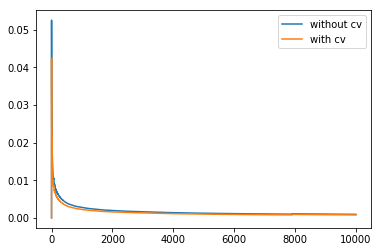

In [261]:
cv_approach("2a", 0.05, 0.05, 10000, 10)

CI_plain [5.333433511607807, 5.333437024685106]
CI_cv [5.333438589208091, 5.3334412331500545]
By using controled variable in 10000 samples, we reduce the length of CI by 24.740000341944 percent 

Generate 10000 sample paths 



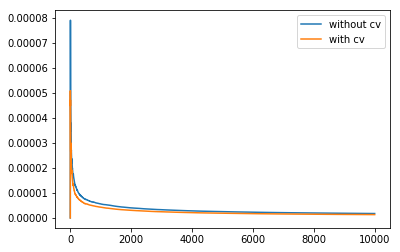

In [246]:
cv_approach("2b", 0.05, 0.05, 10000, 10)

#### Result - Control Variate
By running 10,000 simulations with at least 95% confidence and at most 5% relative error, we achieve some variance reduction for both part a) and b) using control variate $log(S1)$, obtaining 15.7% reduction and 24.7% reduction, respectively.

We notice that variance reduction using control variate is very sensitive to the value of $\beta$ where $W = Y - \beta Z_{cv}$:

1. When $\beta$ value is high, e.g. setting $\beta = 5$, variance reduction is significant for part a) whilst in fact the method does not work and lead to a variance *increase* for part b); 

2. On the other hand, when $\beta$ value is low, e.g. setting $\beta = 0.1$, the variance reduction result is very good for part b) while bringing little effect for part a). 

A control variate that works well for part a) does not necessarily work as well for part b), since we are dealing with different functions of the data and the parameter $\beta$ reflects that sensitivity. Intuitively: $$Var(W) = Var(Y) + \beta^2Var(Z_{cv}) - 2\beta Cov(Y,Z_{cv})$$
there is a trade-off between beta and correlation. If $Y$ and $Z_{cv}$ are highly correlated, the third covariance term will bring down the variance on the control variable $W$, leading to variance reduction in our output. On the other hand, when the control variate $Z_{cv}$ has a somewhat weak correlation with $Y$, we want a very small $\beta$ to ensure the second and third term combined can be negative enough to achieve $Var(W) \leq Var(Y)$.

Through trials and error on parameter tuning, we have selected $\beta = 5$ to run part a) and $\beta = 0.1$ to run part b). As an extension, we could have done regression analysis to obtain the optimal $\beta$ solution for both cases. Using sample estimates of $g(\bar{X}_{2^{n0}})$ for $Y$, and then given $Z_{cv} = log(S1) - log(S0) - p\mu_0 - (1-p)\mu_1$, we can obtain $\hat{\beta}^*$ for $Z_{cv}$ because as we have derived in Lecture 11 of this course,  $\hat{\beta}^*$ is equivalent to the *best fit* from the regression analysis, where:
$$\hat{\beta}^*_n = \frac{cov(Y_i, Z_i)}{var(Z_i)}$$

### Conditional Monte Carlo (CMC) Technique

Lastly, considering the expected utility function that we aim to maximize in this project. There have always been two sources of randomness underlying the dynamics: J ~ Ber(p) and Z ~ N(0,1). The conditional Monte Carlo (CMC) technique shares the same intuition for variance reduction that by conditioning on a source of randomness, one introduces more information into the data structure and hence the variance created in our estimation should be reduced. In CMC, we always want to compute in closed form the source of randomness that contributes *the most*, which in our case would be Z, and therefore we should condition on everything else. 

Thus given J = {0, 1}, we want to condition on Z to apply conditional Monte Carlo technique on our objective function by maximizing the weighted expected utility conditioning on Z as follows:
$$max_\theta \text{ } pE[h_{J1}(Z_i, \theta)] + (1-p)E[h_{J0}(Z_i, \theta)]$$

For instance, on samples of N + 1 the closed form solution for the utility maximization problem is:
$$\hat{\theta}_{2^{N+1}} = argmax(\frac{1}{2^{N+1}}(p\sum{h_{J1}} + (1-p)\sum{h_{J0}}))$$

The implementation procedure for CMC is to re-write the functions that generate *risky_price* and *util_optimiser*. For each random value of $Z_i$ produced in one simulation, we compute two sets of risky price when J = 1 and when J = 0. We can then compute the *util_optimiser_cmc* based on the weighted utilities from the two sets of risky prices, and construct the cool estimator for the multilevel Monte Carlo method as before. We present our results at the end of the simulation. 

In [268]:
def risky_price_cmc(num_samples, S0 = 2):  
    #conditional monte carlo (cmc) variance reduction technique
    ## S1 = S0 * R
    ## log(R_t) = (mu_0 + Z_t * sigma_0) * J_t + (mu_1 + Z_t * sigma_1) * (1 - J_t)
    ## J ~ Ber(p), Z ~ N(0,1)
    
    ## parameter values given
    p = 0.4
    mu_0 = 0.1
    sigma_0 = 0.15
    mu_1 = 0.25
    sigma_1 = 0.3
    
    Z = np.random.normal(0, 1, size = (1, num_samples))
    
    #Given Z, compute two sets of risky prices
    log_R_j1 = (mu_0 + Z * sigma_0)
    log_R_j0 = (mu_1 + Z * sigma_1)
    R_j1 = np.exp(log_R_j1)
    R_j0 = np.exp(log_R_j0)
    
    ## If no variance reduction technique - i.e. plain version
    J = np.random.binomial(1, p, size = (1, num_samples))
    log_R = (mu_0 + Z * sigma_0) * J + (mu_1 + Z * sigma_1) * (1 - J)
    R = np.exp(log_R)
    
    return S0 * R_j1, S0 * R_j0, S0 * R

In [269]:
def util_optimiser_cmc(S1_j1, S1_j0, S1):
    '''
    a function that maximizes the expected utility by solving for the optimal asset allocation between
    the risky and the risk free asset - with CMC technique
    '''
    
    ## parameter values given
    F0 = 1
    S0 = 2  
    b = 200
    rho = 0.01
    p = 0.4 #bernoulli probability for J 
    
    ## F1 = exp(r) * F0
    r = 0.03
    F1 = np.exp(r) * F0
    
    ## max expected utility function
    util = lambda x: (-1) * np.mean(p * np.log((np.max(x[0] * F1 + x[1] * S1_j1 - x[1] ** 2 * rho * S1_j1, 0))) + (1-p) * np.log((np.max(x[0] * F1 + x[1] * S1_j0 - x[1] ** 2 * rho * S1_j0, 0))))

    const = ({'type': 'eq', 'fun': lambda x: (x[0] * F0 + x[1] * S0 + x[1] ** 2 * rho * S0 - b)})

    bnds = ((0, None), (0, None))

    res = minimize(util, (2,1), method = 'SLSQP', bounds = bnds, constraints = const)

    allocation = res.x
    opt = -1 * res.fun
    
    #if no variance reduction teqnique - i.e. plain version
    allocation0, opt0 = util_optimiser(S1)
    
    return (allocation, opt), (allocation0, opt0)

In [270]:
def cmc_approach(Question, delta, epsilon, max_samples, n_0):    
    '''
    This function uses conditional monte carlo technique for Q2 of the Project as a method of variance reduction technique
    '''    
    
    ## Do the experiment
    # experiment variables
    z = sct.norm.ppf( 1 - delta/2 )  # 1 - delta/2 quantile of N(0, 1)
    r_star = 1 - pow( 2, -1.5 )     # optimal success rate for the geometric of N
    
    num_estimator = 0     #count of number of estimators generated                      
    running_mean = np.array([0, 0])    # first is null estimator, second corresponds to using control covariate
    running_2moment = np.array([0, 0])     # same as above

    CIs = np.zeros((2, max_samples))

    while num_estimator < max_samples:
        N = np.random.geometric( p=r_star )

        num_samples = pow(2, N+n_0+1)
        
        samples_j1, samples_j0, samples = risky_price_cmc(num_samples)
        
        samples_odd_j1 = samples_j1[:,0::2]
        samples_even_j1 = samples_j1[:,1::2]
        samples_n_0_j1 = samples_j1[:,0:pow(2,n_0)]
        
        samples_odd_j0 = samples_j0[:,0::2]
        samples_even_j0 = samples_j0[:,1::2]
        samples_n_0_j0 = samples_j0[:,0:pow(2,n_0)]
        
        #if no variance reduction technique - i.e. plain version samples
        samples_odd = samples[:,0::2]
        samples_even = samples[:,1::2]
        samples_n_0 = samples[:,0:pow(2,n_0)]
        
        cmc_Nplus1, no_cmc_Nplus1 =  util_optimiser_cmc(samples_j1, samples_j0, samples)
        cmc_N_odd, no_cmc_N_odd = util_optimiser_cmc(samples_odd_j1, samples_odd_j0, samples_odd)
        cmc_N_even, no_cmc_N_even = util_optimiser_cmc(samples_even_j1, samples_even_j0, samples_even)
        cmc_N0, no_cmc_N0 = util_optimiser_cmc(samples_n_0_j1, samples_n_0_j0, samples_n_0)
        
        if Question == "2a":
            X_star_0 = (no_cmc_Nplus1[0][1] - (no_cmc_N_odd[0][1] + no_cmc_N_even[0][1]) / 2) / sct.geom(r_star).pmf(N+1) + no_cmc_N0[0][1]
            X_star = (cmc_Nplus1[0][1] - (cmc_N_odd[0][1] + cmc_N_even[0][1]) / 2) / sct.geom(r_star).pmf(N+1) + cmc_N0[0][1]
        elif Question == "2b":
            X_star_0 = (no_cmc_Nplus1[1] - (no_cmc_N_odd[1] + no_cmc_N_even[1]) / 2) / sct.geom(r_star).pmf(N+1) + no_cmc_N0[1]
            X_star = (cmc_Nplus1[1] - (cmc_N_odd[1] + cmc_N_even[1]) / 2) / sct.geom(r_star).pmf(N+1) + cmc_N0[1]
        
        X = np.array([X_star_0, X_star])
        running_mean = (running_mean * num_estimator + X) / (num_estimator + 1)
        running_2moment = (running_2moment * num_estimator + np.power(X, 2)) / (num_estimator + 1)
        sample_std = np.sqrt(running_2moment - np.power(running_mean, 2))
        num_estimator = num_estimator + 1
        confidence_interval = z * sample_std / (math.sqrt(num_estimator) * running_mean) #relative error to be computed
        CIs[:,num_estimator-1] = confidence_interval

    
    half_interval_plain = CIs[0,-1]
    half_interval_cv = CIs[1,-1]
    
    CI_plain = [running_mean[0] - half_interval_plain, running_mean[0] + half_interval_plain]
    print('CI_plain', CI_plain)
    CI_cv = [running_mean[1] - half_interval_cv, running_mean[1] + half_interval_cv]
    print('CI_cv', CI_cv)
    
    diff = half_interval_cv - half_interval_plain;
    reduction_percent = (half_interval_plain - half_interval_cv) / half_interval_plain * 100;
    print(f'By using conditional monte carlo in {max_samples} samples, we reduce the length of CI by {reduction_percent} percent \n')
    
    print('Generate', num_estimator , 'sample paths \n')
    n_range = np.arange(num_estimator)
    plt.plot(n_range, CIs[0,n_range],  label='without cv')
    plt.plot(n_range, CIs[1,n_range], label='with cv')
    plt.legend(loc='upper right')
    plt.show()

CI_plain [4.751997747762285, 4.757649514773032]
CI_cv [4.756496173401711, 4.7614490239952225]
By using conditional monte carlo in 1000 samples, we reduce the length of CI by 12.366334562379379 percent 

Generate 1000 sample paths 



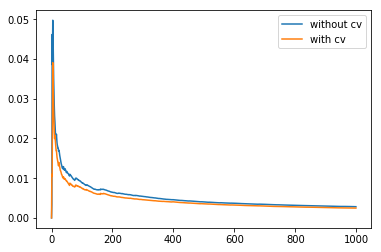

In [226]:
cmc_approach("2a", 0.05, 0.05, 1000,10)

CI_plain [4.7575771306583, 4.75936298995031]
CI_cv [4.7600383536748625, 4.7616294953915625]
By using conditional monte carlo in 10000 samples, we reduce the length of CI by 10.90329883101221 percent 

Generate 10000 sample paths 



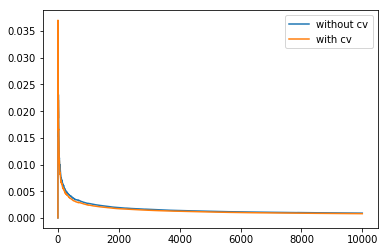

In [227]:
cmc_approach("2a", 0.05, 0.05, 10000,10)

CI_plain [5.333412630499373, 5.333423155671207]
CI_cv [5.333417072916712, 5.333426636013252]
By using conditional monte carlo in 1000 samples, we reduce the length of CI by 9.140708677380173 percent 

Generate 1000 sample paths 



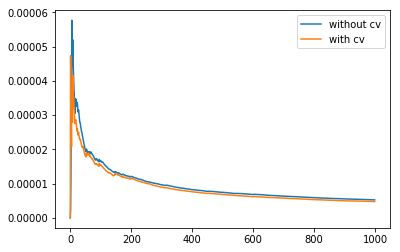

In [228]:
cmc_approach("2b", 0.05, 0.05, 1000,10)

CI_plain [5.333430648277915, 5.333434164862]
CI_cv [5.3334328923736765, 5.333436001158399]
By using conditional monte carlo in 10000 samples, we reduce the length of CI by 11.596462714549935 percent 

Generate 10000 sample paths 



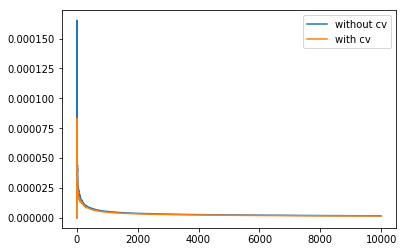

In [229]:
cmc_approach("2b", 0.05, 0.05, 10000,10)

#### Result - Conditional Monte Carlo

The CMC variance reduction technique produces very consistent satisfying results. With 95% confidence level and 5% error, we achieve on average 11% variance reduction for both part a) and b), and the amount of reduction achieved is consistent across different lengths of simulations as I have experimented with both 1,000 simulations and 10,000 simulations. 

## Conclusion

This project explores how best to make a two-period portfolio decision ex-ante by allocating appropriate fund between the risky asset and the risk free asset given a budget constraint, in order to maximize the expected utility function. We have applied various techniques in our estimation for the objective function by using the multilevel Monte Carlo technique, to obtain *unbiased estimators* for the optimal risky asset allocation, the maximium expected utility, and the Value-at-Risk for Loss at 95-th percentile. We then conducted output analysis by applying Central Limit Theory with the specified confidence level and error. 

The next part of the project sets to apply various statistical techniques in reducing the variance for our estimations while maintaining unbiasedness. I explored three different approaches independently on variance reduction that we have learned throughout this course: stratified sampling, control variate, and conditional Monte Carlo. All three techniques help to reduce the variance of our estimators by varying degrees; the best results consistent for both parts of Question 2 are achieved through conditional Monte Carlo, followed by stratefied sampling. 

For improvement, it is possible to achieve better variance reduction by *combining* these three different variance reduction techniques together. For example, we can use control variate $Z_{cv} = log(S1)$ inside the stratified sampling, or we can introduce stratified sampling into our conditional Monte Carlo approach along with a control variate. It is also possible to achieve better variance reduction specifically for control variate, as suggested in the section, by optimizing the value for $\beta$ through regression analysis; alternatively, we can experiment with other more complex forms of control variate that may be more strongly correlated with our original variable, provided we can solve the expectation of the control variate in closed form. 